## Setup

In [248]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl


In [339]:
feature_size_lookup=[27,6,196,9,62,21,21,39,500,10,10,27,29,7,19,3,1555,32,36,32,18,10,6,100,166,64,10,16,8,36,36,9,3,3,57,400,9,6,6,12,21,9,30,5,13,33,8,512,512,512]

def plot_df_across_datasets(file_name:str,all_rla_flag=False,figsize=[8,8]):
    plotting_metric = file_name.split('_')[0]
    df_pr = pd.read_csv(f'data/result/save_result/{file_name}')

    df_pr.insert(0,'Dataset', [df_pr['Unnamed: 0'][i][1:-1].split(',')[0][1:-1] for i in range(len(df_pr['Unnamed: 0']))])
    df_pr.insert(1,'rla', [float(df_pr['Unnamed: 0'][i][1:-1].split(',')[1]) for i in range(len(df_pr['Unnamed: 0']))])
    df_pr.insert(2,'seed', [int(df_pr['Unnamed: 0'][i][1:-1].split(',')[2]) for i in range(len(df_pr['Unnamed: 0']))])
    df_pr.drop('Unnamed: 0',axis=1,inplace=True)
    dataset_list = list(set(df_pr['Dataset']))
    model_list = list(df_pr.columns)[3:]
    plt.figure(figsize=figsize)
    color_maps = {'ssTrue':mpl.colormaps['autumn'],'ssFalse':mpl.colormaps['winter']}
    i_dataset=0;filtered_dataset_list=[]
    legend_flag=False
    for dataset_ in dataset_list:
        dataset_model_data = {}
        for i_model,model_ in enumerate(model_list):
            dataset_model_data[model_] = {}
            model_offset = i_model/len(model_list) *.9
            data_ = df_pr[df_pr['Dataset']==dataset_][model_] if all_rla_flag else df_pr[np.logical_and(df_pr['Dataset']==dataset_, df_pr['rla'] == 1.0)][model_]
            dataset_model_data[model_]['invalid'] = data_.isna().all()
            dataset_model_data[model_]['points'] = [data_.min(),data_.mean(),data_.max()]
            dataset_model_data[model_]['x'] = i_dataset+model_offset
            dataset_model_data[model_]['c'] = color_maps[model_.split('_')[-1]](model_offset)
        if all([dataset_model_data[model_]['invalid'] for model_ in model_list]):
            continue
        for model_ in model_list:
            plt.scatter([dataset_model_data[model_]['x'],]*3,dataset_model_data[model_]['points'],label=model_,
                        c=[dataset_model_data[model_]['c'],]*3,marker='s',s=4)
            plt.vlines(dataset_model_data[model_]['x'],dataset_model_data[model_]['points'][0],dataset_model_data[model_]['points'][-1],
                    colors=[dataset_model_data[model_]['c'],],linewidth=.75)
        if not legend_flag: plt.legend(); legend_flag=True
        filtered_dataset_list.append(dataset_)
        i_dataset+=1
    plt.xticks(range(len(filtered_dataset_list)), filtered_dataset_list,rotation=90)

    plt.xlabel('Datasets')
    plt.ylabel(plotting_metric+' [sec]' if 'Time' in plotting_metric else plotting_metric)
    plt.title(f"Model {plotting_metric} across Datasets (T_len={file_name.split('tseq')[-1].split('_')[0]})")
    return df_pr

def plot_df_across_hyparam(file_name,hyparam_name = 'temporal_width',model_filter={'rla':1.0},figsize=[8,8]):
    if hyparam_name in model_filter.keys(): raise ValueError(f"{hyparam_name = } can't be in the model_filter!")
    plotting_metric = file_name.split('_')[0]
    df = pd.read_csv(f'data/result/save_result/{file_name}')

    df.insert(0,'Dataset', [df['Unnamed: 0'][i][1:-1].split(',')[0][1:-1] for i in range(len(df['Unnamed: 0']))])
    df.insert(1,'rla', [float(df['Unnamed: 0'][i][1:-1].split(',')[1]) for i in range(len(df['Unnamed: 0']))])
    df.insert(2,'seed', [int(df['Unnamed: 0'][i][1:-1].split(',')[2]) for i in range(len(df['Unnamed: 0']))])
    df.insert(3,'feat_size', [feature_size_lookup[int(d.split('_')[0])] for d in df['Dataset']])

    df.drop('Unnamed: 0',axis=1,inplace=True)
    model_list = list(df.columns)[4:]
    feature_size_list = list(set(df['feat_size']))
    feature_size_list.sort()
    rla_list = list(set(df['rla']))
    rla_list.sort()

    def get_hparams_from_name(model_name:str):
        try:
            temporal_depth = int(model_name.split('_')[1].split('x')[0])
            temporal_width = int(model_name.split('_')[1].split('x')[1])
            self_supervised_flag = model_name.split('_')[-1][2:] =='True'
        except Exception as e:
            raise Exception(f"{model_name}:: {e}")
        return {'temporal_depth':temporal_depth, 'temporal_width':temporal_width, 'self_supervised_flag':self_supervised_flag}

    plt.figure(figsize=figsize)
    hyparam_metric={}
    if hyparam_name == 'rla' or hyparam_name == 'feat_size':
        hyparam_range = feature_size_list if hyparam_name == 'feat_size' else rla_list
        for hyparam_ in hyparam_range:
            hyparam_metric[hyparam_]=np.array([])
    else:
        for model_ in model_list:
            hyparam_metric[get_hparams_from_name(model_)[hyparam_name]]=np.array([])
    for model_ in model_list:
        skip_model = False
        for key_ in model_filter.keys():
            if key_ =='rla':continue
            if get_hparams_from_name(model_)[key_] != model_filter[key_]: skip_model=True
        if skip_model: continue
        if hyparam_name == 'rla' or hyparam_name == 'feat_size':
            for hyparam_ in hyparam_range:
                data_ =  df[df[hyparam_name] == hyparam_][model_]
                hyparam_metric[hyparam_]=np.concatenate([hyparam_metric[hyparam_],data_])
        else:
            data_ =  df[df['rla'] == model_filter['rla']][model_] if 'rla' in model_filter.keys() else df[model_]
            hyparam_metric[get_hparams_from_name(model_)[hyparam_name]]=np.concatenate([hyparam_metric[get_hparams_from_name(model_)[hyparam_name]],data_])
    # HACK
    bad_keys=[]
    for k,v in hyparam_metric.items():
        if np.isnan(v).all(): bad_keys.append(k)
    for k in bad_keys:hyparam_metric.pop(k)

    plt.plot(hyparam_metric.keys(),[dd[np.logical_not(np.isnan(dd))].mean() for dd in hyparam_metric.values()],c='#1f77b4')
    plt.scatter(hyparam_metric.keys(),[dd[np.logical_not(np.isnan(dd))].mean() for dd in hyparam_metric.values()],s=5,c='#1f77b4')
    plt.fill_between(hyparam_metric.keys(),[dd[np.logical_not(np.isnan(dd))].min() for dd in hyparam_metric.values()],
            [dd[np.logical_not(np.isnan(dd))].max() for dd in hyparam_metric.values()],alpha=.5,color='#1f77b4')
    # plt.plot(hyparam_metric.keys(),[dd[np.logical_not(np.isnan(dd))].min() for dd in hyparam_metric.values()])
    # plt.plot(hyparam_metric.keys(),[dd[np.logical_not(np.isnan(dd))].max() for dd in hyparam_metric.values()])

    plt.xlabel(hyparam_name)
    plt.xticks(list(hyparam_metric.keys()))
    plt.ylabel(plotting_metric+' [sec]' if 'Time' in plotting_metric else plotting_metric)
    title_string = f"{plotting_metric} across {hyparam_name} (T_len={file_name.split('tseq')[-1].split('_')[0]})"
    for k_ in model_filter.keys():
        title_string+= f"({k_}={model_filter[k_]})"
    plt.title(title_string)
    return df

## Plotting Model metrics across the datasets

/home/jmirenzi/Documents/plotting_scripts/.venv/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


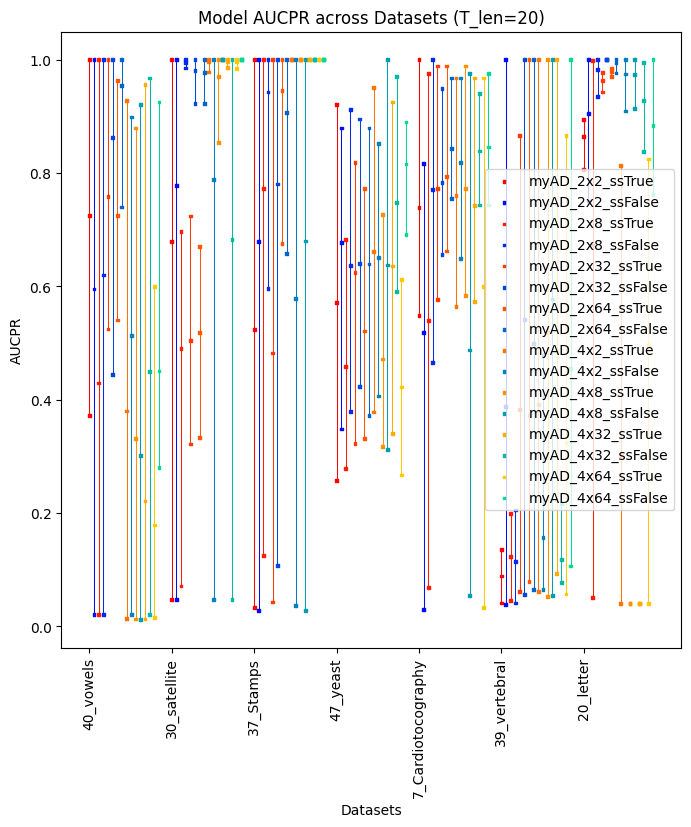

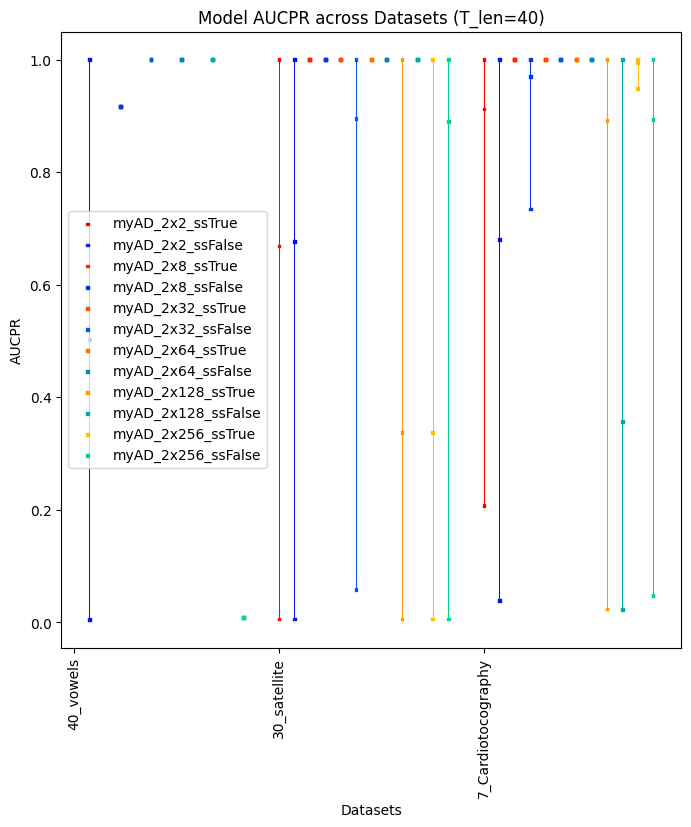

In [263]:
out = plot_df_across_datasets('AUCPR_mulit_tseq20_type(None)_noise(None)_None.csv',all_rla_flag=True)
out = plot_df_across_datasets('AUCPR_mulit_tseq40_type(None)_noise(None)_None.csv',all_rla_flag=True)
# out = plot_df_across_datasets('AUCPR_mulit_tseq40_type(None)_noise(None)_None.csv',all_rla_flag=True)

In [254]:
out[out['Dataset']=='30_satellite']['myAD_2x2_ssTrue']

45         NaN
46         NaN
47         NaN
48    0.047619
49    0.981635
50    0.047619
51    1.000000
52    1.000000
53    1.000000
Name: myAD_2x2_ssTrue, dtype: float64

/home/jmirenzi/Documents/plotting_scripts/.venv/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


,Dataset,rla,seed,myAD_2x2_ssTrue,myAD_2x2_ssFalse,myAD_2x8_ssTrue,myAD_2x8_ssFalse,myAD_2x32_ssTrue,myAD_2x32_ssFalse,myAD_2x64_ssTrue,myAD_2x64_ssFalse,myAD_4x2_ssTrue,myAD_4x2_ssFalse,myAD_4x8_ssTrue,myAD_4x8_ssFalse,myAD_4x32_ssTrue,myAD_4x32_ssFalse,myAD_4x64_ssTrue,myAD_4x64_ssFalse
0,47_yeast,1.00,1,0.691667,0.883333,0.825000,0.833333,0.891667,0.858333,0.825000,0.933333,0.841667,0.941667,0.466667,0.875000,0.900000,0.983333,0.541667,0.950000
1,47_yeast,1.00,2,0.958333,0.825000,0.691667,0.825000,0.825000,0.858333,0.758333,0.875000,0.783333,0.866667,0.575000,0.958333,0.791667,0.925000,0.683333,0.933333
2,47_yeast,1.00,3,0.641667,0.825000,0.491667,0.858333,0.866667,0.766667,0.883333,0.858333,0.966667,0.783333,0.508333,0.475000,0.825000,0.866667,0.591667,0.908333
3,47_yeast,0.75,1,NaN,0.625000,NaN,0.550000,NaN,0.750000,NaN,0.866667,NaN,0.616667,NaN,1.000000,NaN,0.875000,NaN,0.816667
4,47_yeast,0.75,2,NaN,0.758333,NaN,0.950000,NaN,0.925000,NaN,0.883333,NaN,0.833333,NaN,0.716667,NaN,0.875000,NaN,0.925000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,33_skin,0.75,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
203,33_skin,0.75,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204,33_skin,0.50,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
205,33_skin,0.50,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


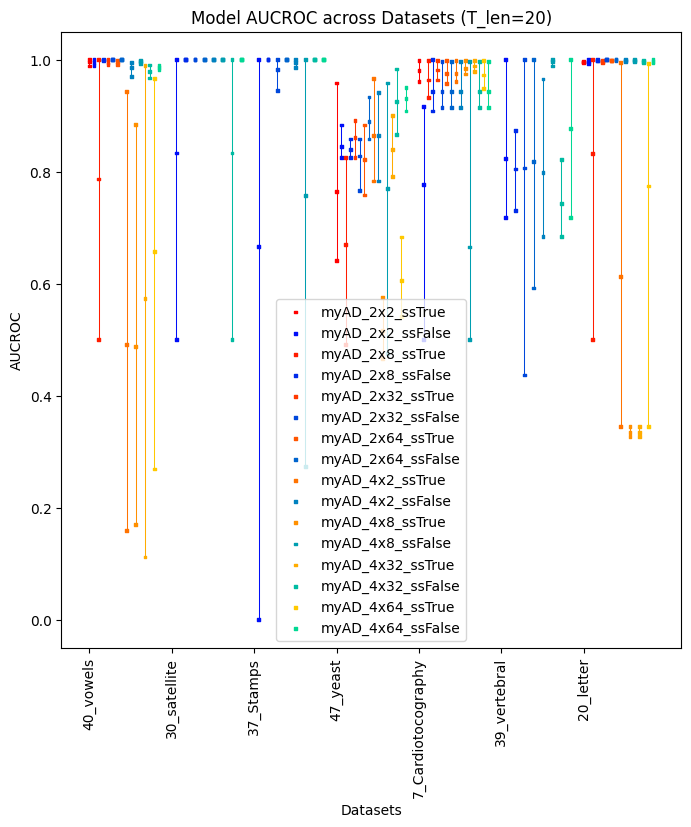

In [273]:
plot_df_across_datasets('AUCROC_mulit_tseq20_type(None)_noise(None)_None.csv')

/home/jmirenzi/Documents/plotting_scripts/.venv/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


,Dataset,rla,seed,myAD_2x2_ssTrue,myAD_2x2_ssFalse,myAD_2x8_ssTrue,myAD_2x8_ssFalse,myAD_2x32_ssTrue,myAD_2x32_ssFalse,myAD_2x64_ssTrue,myAD_2x64_ssFalse,myAD_4x2_ssTrue,myAD_4x2_ssFalse,myAD_4x8_ssTrue,myAD_4x8_ssFalse,myAD_4x32_ssTrue,myAD_4x32_ssFalse,myAD_4x64_ssTrue,myAD_4x64_ssFalse
0,47_yeast,1.00,1,27.619760,21.536611,21.178144,20.643049,21.091936,20.703554,20.717602,20.413141,34.528291,33.154393,34.083014,33.138716,34.169975,34.985023,34.075085,33.587635
1,47_yeast,1.00,2,21.259943,20.426679,21.102410,20.429544,20.848890,21.049861,21.244017,20.636075,33.625066,33.277140,34.165646,32.942091,33.404927,33.265737,34.914191,34.203241
2,47_yeast,1.00,3,20.911805,21.386784,22.571919,22.009619,21.225099,20.598663,20.945567,20.965348,33.704675,34.865775,34.438826,33.793465,33.550592,34.225623,34.904097,35.142172
3,47_yeast,0.75,1,NaN,22.988853,NaN,23.170760,NaN,22.538497,NaN,23.146045,NaN,36.402366,NaN,36.401147,NaN,35.454519,NaN,34.371229
4,47_yeast,0.75,2,NaN,22.164689,NaN,22.408001,NaN,21.655353,NaN,22.248717,NaN,35.853472,NaN,33.906213,NaN,33.398264,NaN,35.631783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,33_skin,0.75,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
203,33_skin,0.75,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204,33_skin,0.50,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
205,33_skin,0.50,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


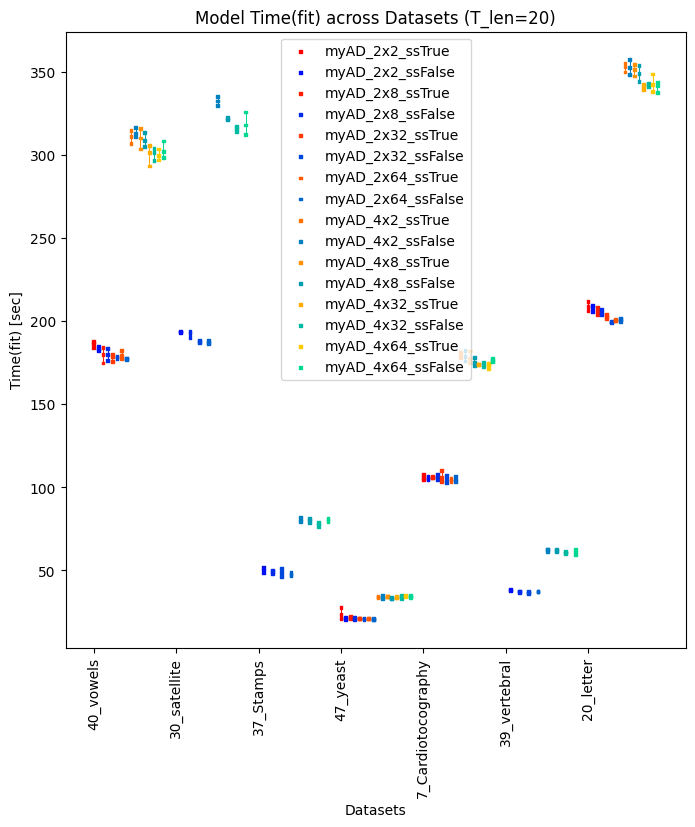

In [258]:
plot_df_across_datasets('Time(fit)_mulit_tseq20_type(None)_noise(None)_None.csv')

/home/jmirenzi/Documents/plotting_scripts/.venv/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


,Dataset,rla,seed,myAD_2x2_ssTrue,myAD_2x2_ssFalse,myAD_2x8_ssTrue,myAD_2x8_ssFalse,myAD_2x32_ssTrue,myAD_2x32_ssFalse,myAD_2x64_ssTrue,myAD_2x64_ssFalse,myAD_4x2_ssTrue,myAD_4x2_ssFalse,myAD_4x8_ssTrue,myAD_4x8_ssFalse,myAD_4x32_ssTrue,myAD_4x32_ssFalse,myAD_4x64_ssTrue,myAD_4x64_ssFalse
0,47_yeast,1.00,1,0.092234,0.092393,0.092779,0.090478,0.104361,0.093154,0.093932,0.092837,0.122559,0.121495,0.121228,0.120813,0.119855,0.118554,0.120758,0.121474
1,47_yeast,1.00,2,0.092918,0.089081,0.099018,0.091031,0.094931,0.090975,0.089806,0.090419,0.118553,0.117725,0.118443,0.116449,0.116475,0.117988,0.118696,0.122932
2,47_yeast,1.00,3,0.093349,0.089461,0.095633,0.090356,0.089392,0.091638,0.091748,0.091928,0.125877,0.117743,0.115564,0.116388,0.136858,0.121004,0.118927,0.125235
3,47_yeast,0.75,1,NaN,0.096539,NaN,0.098200,NaN,0.092440,NaN,0.104758,NaN,0.125550,NaN,0.117690,NaN,0.121879,NaN,0.115461
4,47_yeast,0.75,2,NaN,0.090438,NaN,0.091808,NaN,0.092564,NaN,0.090848,NaN,0.122701,NaN,0.116796,NaN,0.120942,NaN,0.114798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,33_skin,0.75,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
203,33_skin,0.75,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204,33_skin,0.50,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
205,33_skin,0.50,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


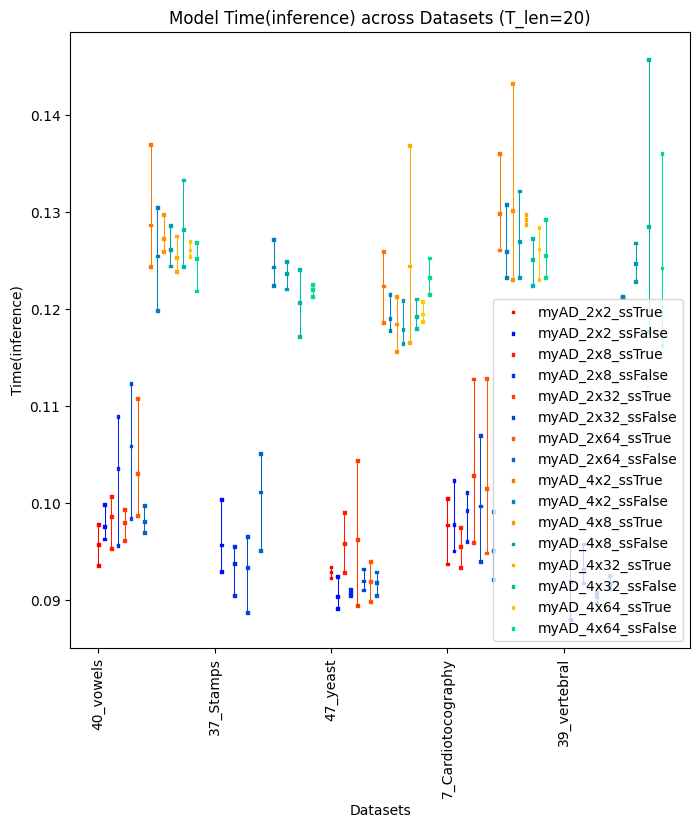

In [145]:
plot_df_across_datasets('Time(inference)_mulit_tseq20_type(None)_noise(None)_None.csv')

## Plotting Model Metrics across Hyperparameters

In [338]:
# [dd[np.logical_not(np.isnan(dd))].min() for dd in oo.values()]
bad_keys=[]
for k,v in oo.items():
    if np.isnan(v).all(): bad_keys.append(k)
for k in bad_keys:oo.pop(k)
oo

{18: array([       nan,        nan,        nan,        nan,        nan,
               nan, 0.97418434, 0.65131915, 0.48552946, 1.        ,
        1.        , 0.90212363, 1.        , 0.95491862, 1.        ,
        0.03938731, 1.        , 1.        ,        nan,        nan,
               nan,        nan,        nan,        nan, 0.03938731,
        0.15011527, 0.89313707, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.84457774,
        1.        ,        nan,        nan,        nan,        nan,
               nan,        nan, 1.        , 0.82825667, 0.9835457 ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.97267237, 1.        , 1.        ,        nan,
               nan,        nan,        nan,        nan,        nan,
        1.        , 0.99206349, 0.98611111, 1.        , 0.95505572,
               nan, 1.        , 0.98724941, 0.84310912, 1.        ,
        0.96624061, 1.        ,        nan, 

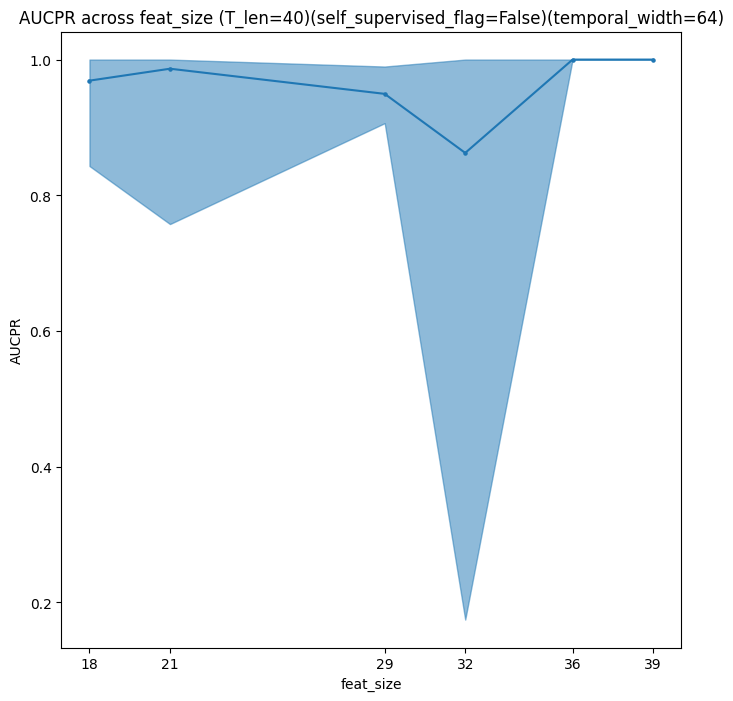

In [341]:
oo=plot_df_across_hyparam(
                        'AUCPR_mulit_tseq40_type(None)_noise(None)_None.csv',
                        # 'Time(fit)_mulit_tseq20_type(None)_noise(None)_None.csv',
                      #  hyparam_name='temporal_width',
                      #  hyparam_name='temporal_depth',
                      #  hyparam_name='rla',
                       hyparam_name='feat_size',
                      #  model_filter={'self_supervised_flag':True},
                      #  model_filter={'self_supervised_flag':False},
                       model_filter={'self_supervised_flag':False,'temporal_width':64},
                       )

In [173]:
hyparam_metric[2][np.logical_not(np.isnan(hyparam_metric[2]))]

array([0.56268091, 0.92068452, 0.50761183, 0.96749276, 0.67130578,
       0.58230591, 1.        , 0.47135426, 0.89694966, 0.87916667,
       0.6762602 , 0.74993236, 0.10664488, 0.11944444, 1.        ,
       0.02778123, 1.        , 1.        , 0.05485232, 0.76382647,
       0.79916079, 0.53239348, 0.81472663, 1.        , 0.04761905,
       1.        , 0.83847403, 0.72594246, 0.95028409, 0.96749276,
       0.76055056, 0.56447259, 0.01368465, 0.17194045, 0.01754659,
       0.83387897, 0.70727814, 0.5975018 , 0.47777778, 0.11699346,
       0.09396825, 1.        , 0.86111111, 1.        , 0.93156672,
       0.75466896, 0.81691227, 0.26574472, 0.56480279, 0.80509861,
       1.        ])

In [203]:
tt={}
tt[[2,3,4]]=None

TypeError: unhashable type: 'list'

In [163]:
tt={2:np.ones((4,)),8:np.ones((4,))*3}
[aa.min() for aa in tt.values()]

[1.0, 3.0]